# Creating a striplog from an image

In this recipe we will show how to create a `striplog` from one Peter Giles' images.

First, import modules we might need

In [1]:
import matplotlib.pyplot as plt
% matplotlib inline

import numpy as np

import striplog
striplog.__version__

'0.6.1'

## Making a striplog

In [2]:
from striplog import Striplog, Legend
imgfile = "data/images/P-140_Giles_15_1527.png"

Let's take a look at the <b>image</b>. This is not yet a striplog. Use `imread` to create a numpy array, `im`, from the image.


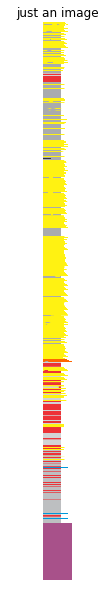

In [3]:
from pylab import imread
im = imread(imgfile)
plt.figure(figsize=(2,10))
plt.imshow(im, aspect=0.5)
plt.axis('off')
plt.title("just an image")
plt.show()

# Make a legend

In [4]:
# Peter Giles Legend

LEGEND_GILES = """colour, width, component lithology, component colour
#FFF057, 6, Sandstone, Grey,
#A9ABAE, 4, Siltstone, Grey,
#EF303D, 4, Siltstone, Red,
#FF642A, 4, Conglomerate, ,
#373435, 2, Coal, ,
#009AD4, 4, Dolomite, ,
#A95286, 7, Rhyolite, ,
"""

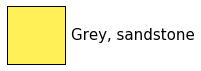

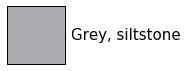

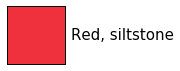

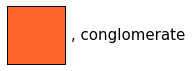

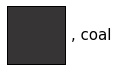

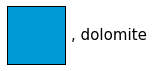

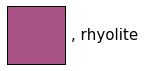

In [5]:
legend = Legend.from_csv(LEGEND_GILES)
legend.plot()

In the file name we have indicated the top (25 m) and bottom (2618 m) extents of the image. 

In [6]:
top, base = 15.0, 1527.0
tolerance = 100  # increase this number to allow for more tolerance to colour match with legend
strip = Striplog.from_image(imgfile, top, base, tolerance = 100, legend=legend)
strip

/Users/Evan/anaconda/envs/welly/lib/python3.5/site-packages/striplog/legend.py:755: UserWarning: No match found for #ffffff with tolerance of 100. Best match is Grey, siltstone, #a9abae, d=144.9586147836685
  warnings.warn(w)


Striplog(476 Intervals, start=15.0, stop=1527.0)

In [7]:
strip.thinnest()

Interval({'top': Position({'middle': 574.2525164113786, 'units': 'm'}), 'components': [Component({'colour': 'grey', 'lithology': 'siltstone'})], 'description': '', 'base': Position({'middle': 574.4179431072209, 'units': 'm'})})

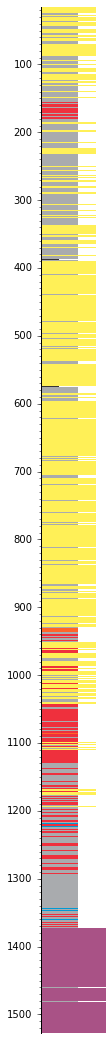

In [8]:
%matplotlib inline
strip.plot(legend, ladder=True)

Do we need to deal with gaps or overlaps?

In [9]:
# let's see if there are any
print(strip.find_gaps())

None


In [10]:
strip.start.z, strip.stop.z

(15.0, 1527.0)

In [11]:
print(strip.read_at(1000.0, index=True))

204


It's easy to form a chunk of LAS3-style text using the `striplog.to_las3()` method:

In [12]:
step = 0.1524  # desired sample interval of output logs
lith = strip.to_log(step=step, legend=legend)
gs, z, table = strip.to_log(legend=legend, legend_field='width', return_meta=True, step=step)

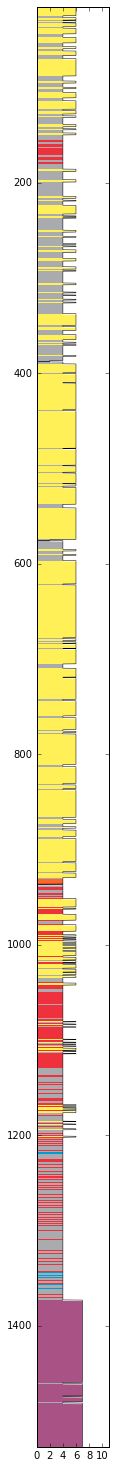

In [13]:
width = 10

fig = plt.figure(figsize=(1,20))
ax = fig.add_axes([0, 0, 1, 1])
ax = strip.plot_axis(ax, legend, default_width=width+1)

plt.plot(gs, z, color='k', lw=0.5)
plt.fill_betweenx(z, gs, width+1, edgecolor='white', facecolor='white', zorder=2)

ax.set_xlim([0, width+1])
ax.set_ylim([strip.stop.z, strip.start.z])
plt.show()

## Create a well object to get all the header information we want

But anything to do with well-level operations or data happens in `Well`. So to write an entire LAS3 file, we'll need `well.striplogs_to_las3()`. However, this only works reliably if we already have an LAS file containing details like KB and so on. We don't have all this information for these wells, so we will just use our template directly and write some very simple LAS3 files.

In [14]:
# from welly import Well

In [15]:
from welly import Curve

In [16]:
# curve parameters are things you want associated with the curve in the lasfile
litho_params = {'description': 'Peter Giles lithology',
                'mnemonic':'Lith',
                'start':strip.start.z, 
                'step':step,
                'units':None}

grain_params = {'description': 'Peter Giles grainsize',
                'mnemonic':'grsz',
                'start':strip.start.z, 
                'step':step,
                'units':None}

In [17]:
grainCurve = Curve(gs, grain_params)
lithCurve = Curve(lith, litho_params)
lithCurve

Curve([1, 1, 1, ..., 7, 7, 7])

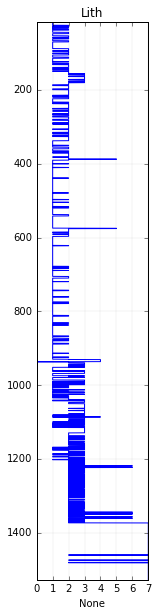

In [18]:
lithCurve.plot()

In [19]:
lithCurve.start, lithCurve.stop

(15.0, 1527.2652)

## Create a well object so we can add our new curves to it

In [104]:
from welly import Well

In [115]:
# existing LAS file to instantiate a well
lasfile = 'data/las/P-140_out.LAS'

In [116]:
# create a well 
well = Well.from_las(lasfile)

# Add the new curves to the collection of curves in well.data

In [117]:
well.data['grsz'] = grainCurve
well.data['lith'] = lithCurve

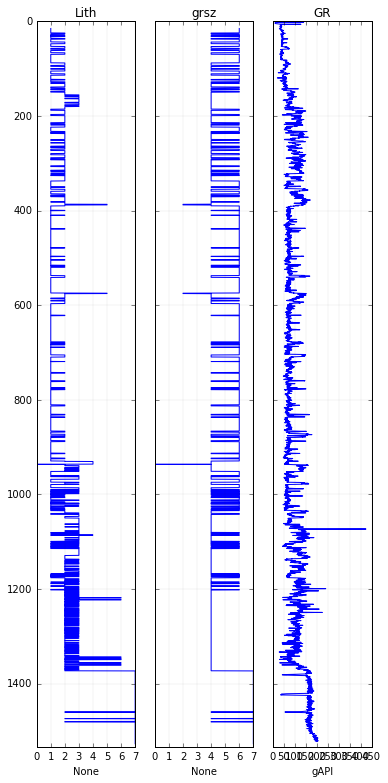

In [118]:
tracks = ['lith','grsz','GR']
well.plot(tracks=tracks)

Use the `welly.to_las()` method to export curves to las to las

but first we need to `resample` our two new curves so they have the same number of depth samples as the logs 



In [119]:
gr = well.data['GR']
gr.start, gr.stop, gr.step

(0.0, 1533.6012, 0.1524)

In [120]:
well.data['grsz'].start, well.data['grsz'].stop, well.data['grsz'].step

(15.0, 1527.2652, 0.1524)

In [157]:
well

In [121]:
d = (gr.start, gr.stop, gr.step)

In [123]:
grainCurve

Curve([ 6.,  6.,  6., ...,  7.,  7.,  7.])

In [134]:
gr

Curve([ 63.19017029,  31.69704056,  22.34020042, ...,          nan,
                nan,          nan])

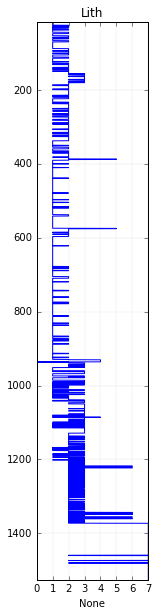

In [174]:
test = lithCurve.segment((well.data['lith'].start, well.data['lith'].stop-1, gr.step))
test.plot()

In [111]:

for key in well.data:
    temp = well.data[key]
    if not well.data[key].shape == well.data['grsz'].shape:
        well.data[key] = well.data[key].segment(d)

In [113]:
well.data['GR'].shape, well.data['grsz'].shape

((9923,), (9923,))

In [114]:
well.to_las('P-140_strip_log_plus_curves.las', lithCurve.basis)

IndexError: index 1 is out of bounds for axis 0 with size 1